# Reproduce Fig 71 from Sorensen, 1985.

Here, the Sorensen model is modified to include a intravenous glucose infusion. The Sorensen model had already been encoded in the YAML format, and is loaded in, then modified, then plotted to reproduce the thesis figure.

In [1]:
import amici
import amici.plotting
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import yaml2sbml
from yaml2sbml import YamlModel

Here, the model of glucose and insulin metabolism, from the thesis of Thomas
J. Sorensen, 1985 [1], is used as an example of how the `yaml2sbml`
`YamlModel` class can be used to easily extend a pre-existing `yaml2sbml`
model.

Specifically, the model is edited to reproduce a figure from the original
thesis (Fig 71) [1].

The implementation that is loaded here is based on the implementation
provided by Panunzi et al., 2020 [2].

In [2]:
yaml_model = YamlModel.load_from_yaml('Sorensen1985.yaml')

The loaded model is customized to reproduce the figure then exported to a new
[SBML](http://sbml.org/) file.

Specifically, an intravenous infusion administration of glucose is added to the
model. Glucose is infused at a rate of 64.81 mM/min for a three-minute period.

In [3]:
# The formula to describe the intravenous glucose infusion.
ivg_formula = 'piecewise(64.81, 17 <= time && time < 20, 0)'
# Add the formula to the model, with identifier `IVG`.
yaml_model.add_assignment('IVG', ivg_formula)

# Link the infusion to the heart space `GlucH`. The infusion is applied to
# veins, so can be implemented in the heart space, instead of a vascular space.
gluch_ode = yaml_model.get_ode_by_id('GlucH')  # Get the current ODE.
gluch_rhs = gluch_ode['rightHandSide']
gluch_initial = gluch_ode['initialValue']
# Modify the ODE. The infusion rate is divided by the volume of the space, as
# concentrations are modeled.
gluch_rhs += '+ (IVG / VolGH)'
# Set the new ODE.
yaml_model.add_ode('GlucH', gluch_rhs, gluch_initial, over_write=True)

# Output the YAML model to SBML format, for use with SBML-compatible tools.
yaml_model.write_to_sbml('Fig71_Sorensen1985.xml', over_write=True)

The model is now setup to reproduce to the figure.
[AMICI](https://github.com/AMICI-dev/AMICI) is used to simulated the model.
First, the model must be imported by AMICI. Observables are defined, which
describe the transformation of model states into the units from the original
figure.

In [4]:
# Define the variables that will be plotted to reproduce the figure from the
# original thesis.
observables = {
    'blood_glucose': {
        'name': 'Blood glucose concentration [mg/dL]',
        # GlucPV: model state for glucose in the peripheral vascular space.
        # Multiplied by 18.0156 to convert [mmol/L] to [mg/dL].
        # Multiplied by 0.84 as described in Panunzi et al. 2020 [2].
        'formula': 'GlucPV * 18.0156 * 0.84',
    },
    'plasma_insulin': {
        'name': 'Plasma insulin concentration [mU/L]',
        # InsuPV: model state for insulin in the peripheral vascular space.
        # Multiplied by 0.144 to convert [pM] to [mU/L].
        'formula': 'InsuPV * 0.144',
    }
}

# Compile the model with AMICI.
sbml_importer = amici.sbml_import.SbmlImporter('Fig71_Sorensen1985.xml')
sbml_importer.sbml2amici(
    model_name='Fig71_Sorensen1985',
    output_dir=os.path.join('amici_models', 'Fig71_Sorensen1985'),
    observables=observables,
)

# Import the compiled model.
sys.path.insert(
    0,
    os.path.abspath(os.path.join('amici_models', 'Fig71_Sorensen1985'))
)
model_module = importlib.import_module('Fig71_Sorensen1985')
model = model_module.getModel()

The model is now ready to simulate. Observables are plotted, which closely match
the original thesis figures.

Note that this figure has a shift in the x-axis, as the simulation here
started at `time == 0`, but in the thesis started at approximately `time == -20`.
As there are no explicit time dependencies in the model, the figure is
otherwise similar.

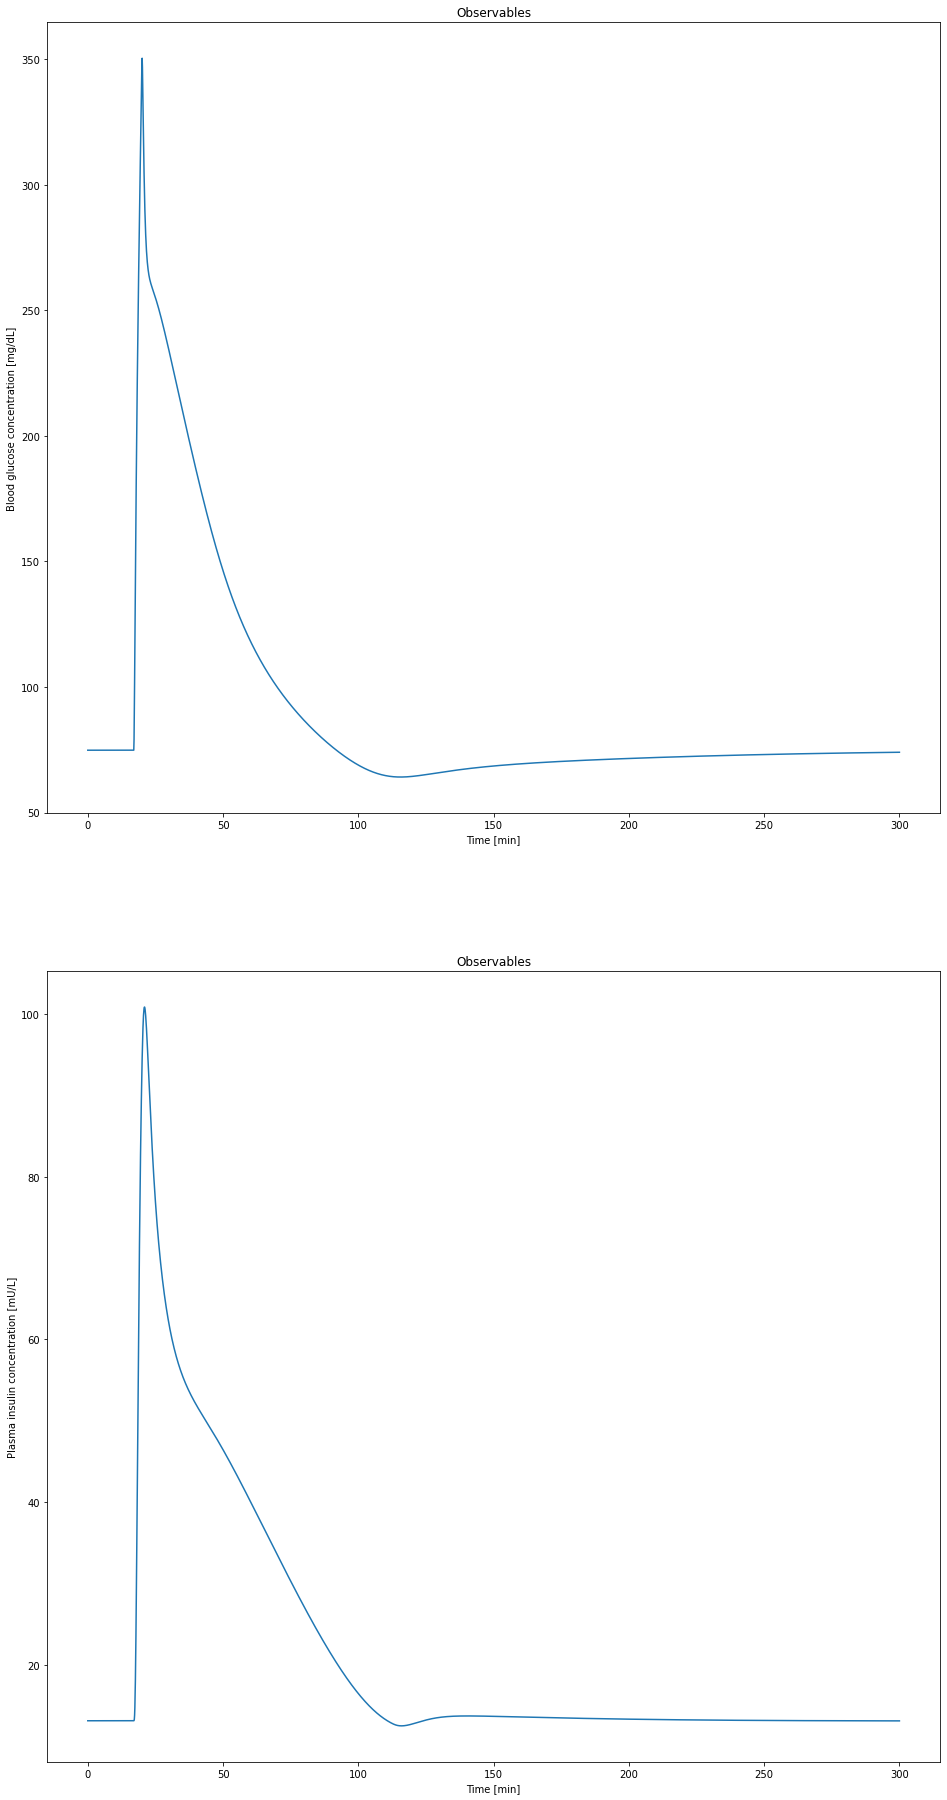

In [5]:
# Simulate.
model.setTimepoints(np.linspace(0, 300, 3001))
solver = model.getSolver()
simulation = amici.runAmiciSimulation(model, solver)

# Reproduce the figure.
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,32))

amici.plotting.plotObservableTrajectories(
    simulation,
    observable_indices=[0],
    model=model,
    ax=ax1,
)
ax1.set_xlabel('Time [min]')
ax1.set_ylabel(observables['blood_glucose']['name'])
ax1.get_legend().remove()

amici.plotting.plotObservableTrajectories(
    simulation,
    observable_indices=[1],
    model=model,
    ax=ax2,
)
ax2.set_xlabel('Time [min]')
ax2.set_ylabel(observables['plasma_insulin']['name'])
ax2.get_legend().remove()

plt.show()

# References

[1] Sorensen, J. T. (1985).
"A physiologic model of glucose metabolism in man and its use 
to design and assess improved insulin therapies for diabetes."
https://dspace.mit.edu/handle/1721.1/15234

[2] Panunzi, S., Pompa, M., Borri, A., Piemonte, V., & De Gaetano, A. (2020).
A revised Sorensen model: Simulating glycemic and insulinemic response to oral
and intra-venous glucose load. Plos one, 15(8), e0237215.
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0237215